In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length

def uplift_curve(y_true, uplift, treatment):
    

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):
   

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
   

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
import numpy as np
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
from sklearn.metrics import auc

from torch.autograd import Variable


from numpy import asarray
from numpy import savez_compressed

In [ ]:
!git clone https://github.com/pianonyy/UPLIFT_modeling.git

Cloning into 'UPLIFT_modeling'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 567 (delta 153), reused 192 (delta 74), pack-reused 266
Receiving objects: 100% (567/567), 13.66 MiB | 13.55 MiB/s, done.
Resolving deltas: 100% (265/265), done.


In [ ]:
!pip install -e UPLIFT_modeling/

Obtaining file:///content/UPLIFT_modeling
  Running setup.py develop for uplift


In [ ]:
import logging
from os.path import join as pjoin
from typing import Tuple

import pandas as pd
from sklearn.preprocessing import LabelEncoder

N_PURCHASES_ROWS = None
DATA_PATH = '/content/drive/MyDrive/' 
logger = logging.getLogger(__name__)


def load_clients() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'clients.csv'),
        parse_dates=['first_issue_date', 'first_redeem_date'],
    )


def prepare_clients() -> Tuple[pd.DataFrame, LabelEncoder]:
    logger.info('Preparing clients...')
    clients = load_clients()
    client_encoder = LabelEncoder()
    clients['client_id'] = client_encoder.fit_transform(clients['client_id'])
    logger.info('Clients are ready')
    return clients, client_encoder


def load_products() -> pd.DataFrame:
    return pd.read_csv(pjoin(DATA_PATH, 'products.csv'))


def prepare_products() -> Tuple[pd.DataFrame, LabelEncoder]:
    logger.info('Preparing products...')
    products = load_products()
    product_encoder = LabelEncoder()
    products['product_id'] = product_encoder. \
        fit_transform(products['product_id'])

    products.fillna(-1, inplace=True)

    for col in [
        'level_1', 'level_2', 'level_3', 'level_4',
        'segment_id', 'brand_id', 'vendor_id',
    ]:
        products[col] = LabelEncoder().fit_transform(products[col].astype(str))
    logger.info('Products are ready')
    return products, product_encoder


def load_purchases() -> pd.DataFrame:
    logger.info('Loading purchases...')
    purchases = pd.read_csv(
        pjoin(DATA_PATH, 'purchases.csv'),
        nrows=N_PURCHASES_ROWS,
    )
    logger.info('Purchases are loaded')
    return purchases


def prepare_purchases(
        client_encoder: LabelEncoder,
        product_encoder: LabelEncoder,
) -> pd.DataFrame:
    logger.info('Preparing purchases...')
    purchases = load_purchases()

    logger.info('Handling n/a values...')
    purchases.dropna(
        subset=['client_id', 'product_id'],
        how='any',
        inplace=True,
    )
    purchases.fillna(-1, inplace=True)

    logger.info('Label encoding...')
    purchases['client_id'] = client_encoder.transform(purchases['client_id'])
    purchases['product_id'] = product_encoder.transform(purchases['product_id'])
    for col in ['transaction_id', 'store_id']:
        purchases[col] = LabelEncoder(). \
            fit_transform(purchases[col].astype(str))

    logger.info('Date and time conversion...')
    purchases['datetime'] = pd.to_datetime(
        purchases['transaction_datetime'],
        format='%Y-%m-%d %H:%M:%S',
    )
    purchases.drop(columns=['transaction_datetime'], inplace=True)

    logger.info('Purchases are ready')
    return purchases


def load_train() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'uplift_train.csv'),
        index_col='client_id',
    )


def load_test() -> pd.DataFrame:
    return pd.read_csv(
        pjoin(DATA_PATH, 'uplift_test.csv'),
        index_col='client_id',
    )


In [ ]:
!unzip /content/drive/MyDrive/features.zip

Archive:  /content/drive/MyDrive/features.zip
  inflating: features.pkl            


In [ ]:
!pip install pickle5

     |████████████████████████████████| 133kB 7.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219253 sha256=7245a3b28da818a3793dc58eb09f00bdd082b379d5dbbce1e3c31f8ab8e38b30
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
import pickle5

RANDOM_STATE = 12

from sklearn.model_selection import train_test_split

train = load_train()
indices_train = train.index
with open('features.pkl', 'rb') as f:
        features: pd.DataFrame = pickle5.load(f)

features.set_index('client_id', inplace=True)
X_train = features.loc[indices_train, :]



treatment_train = train.loc[indices_train, 'treatment_flg'].values
y_train = train.loc[indices_train, 'target'].values

X_train['treatment'] = treatment_train
X_train['target'] = y_train

X_train.loc[(X_train['target'] == 1) & (X_train['treatment'] == 1),'Z_trans'] = 2
X_train.loc[(X_train['target'] == 1) & (X_train['treatment'] == 0),'Z_trans'] =  -2
X_train.loc[X_train['Z_trans'].isnull(), 'Z_trans'] = 0

print(X_train[['Z_trans','treatment','target']])



indices_learn, indices_valid = train_test_split(
        X_train.index,
        test_size=0.3,
        random_state = RANDOM_STATE,
)

all = X_train.copy()
X_train =all.loc[indices_learn,]
X_test = all.loc[indices_valid,]


treatment_train = X_train['treatment']
y_train = X_train['target']
Z_trans_train = X_train['Z_trans']

treatment_test = X_test['treatment']
y_test = X_test['target']
Z_trans_test = X_test['Z_trans']


X_train=X_train.drop('Z_trans',axis = 1)
X_train=X_train.drop('target',axis = 1)
X_train=X_train.drop('treatment',axis = 1)

X_test=X_test.drop('Z_trans',axis = 1)
X_test=X_test.drop('target',axis = 1)
X_test=X_test.drop('treatment',axis = 1)


# print(treatment_test)
# print(treatment_train)

print("propensity score in train:", treatment_train[treatment_train == 1].shape[0] / treatment_train.shape[0])
print("propensity score in test:", treatment_test[treatment_test == 1].shape[0] / treatment_test.shape[0])



            Z_trans  treatment  target
client_id                             
000012768d     -2.0          0       1
000036f903      2.0          1       1
00010925a5      2.0          1       1
0001f552b0      2.0          1       1
00020e7b18      2.0          1       1
...             ...        ...     ...
fffcb91f10      0.0          1       0
fffd5cd0c6      2.0          1       1
fffd63dfe3      2.0          1       1
fffd8c9d7d      0.0          1       0
fffe0abb97      0.0          0       0

[200035 rows x 3 columns]
propensity score in train: 0.49853596526309774
propensity score in test: 0.5027911549549249


In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn import preprocessing

# Z_train_dummies = pd.get_dummies(Z_trans_train)
# Z_test_dummies = pd.get_dummies(Z_trans_test)

# print(Z_train_dummies)
# print(Z_test_dummies)

            -2.0   0.0   2.0
client_id                   
5803624422     0     1     0
20b7b05f7d     1     0     0
0c10e0113f     0     1     0
1761677f2d     0     0     1
aa188a0008     1     0     0
...          ...   ...   ...
4ef8dd16ad     0     0     1
a54f58238b     0     0     1
2e7eeaca71     0     1     0
332b911361     0     0     1
c13eba9d88     0     1     0

[140024 rows x 3 columns]
            -2.0   0.0   2.0
client_id                   
353f2648f3     0     1     0
f0d6002166     0     1     0
af4f3039fe     0     0     1
34b4ce6c2a     0     0     1
7046ea76d3     0     0     1
...          ...   ...   ...
d5c9592f5f     1     0     0
555d2436d3     1     0     0
bc21e85e6e     1     0     0
aa4d24e82f     0     1     0
ad18c83a2e     0     0     1

[60011 rows x 3 columns]


In [ ]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler(with_std = True, with_mean = True)

X_train_0 = X_train.copy()
# X_train_0['treatment'] = 0

X_train_1 = X_train.copy()
# X_train_1['treatment'] = 1

X_train_1 = X_train_1.astype('float32')
X_train_1 = X_train_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_1 = scaler.fit_transform(X_train_1)

X_train_0 = X_train_0.astype('float32')
X_train_0 = X_train_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_0 = scaler.fit_transform(X_train_0)


X_test_0 = X_test.copy()
# X_test_0['treatment'] = 0

X_test_1 = X_test.copy()
# X_test_1['treatment'] = 1

X_test_1 = X_test_1.astype('float32')
X_test_1 = X_test_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_1 = scaler.fit_transform(X_test_1)

X_test_0 = X_test_0.astype('float32')
X_test_0 = X_test_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_0 = scaler.fit_transform(X_test_0)

X_test_0 = np.c_[ X_test_0, np.zeros(X_test_0.shape[0]) ]
X_test_1 = np.c_[ X_test_1, np.ones(X_test_1.shape[0]) ] 

X_train_0 = np.c_[ X_train_0, np.zeros(X_train_0.shape[0]) ]
X_train_1 = np.c_[ X_train_1, np.ones(X_train_1.shape[0]) ]

# X_train_0 = np.c_[ X_train_0, treatment_train ]
# X_train_1 = np.c_[ X_train_1, treatment_train ]

# X_train_0 = np.c_[ X_train_0, y_train ]
# X_train_1 = np.c_[ X_train_1, y_train ]

# X_train_0 = np.c_[ X_train_0, Z_trans_train ]
# X_train_1 = np.c_[ X_train_1, Z_trans_train ]






print(X_train_0, "size = ", type(X_train_0))
print(X_train_1, "size = ", X_train_1.shape)

print(X_test_0, "size = ", X_test_0.shape)
print(X_test_1, "size = ", X_test_1.shape)


# np.savetxt('train_0.txt', X_train_0, delimiter=',')
# np.savetxt('train_1.txt', X_train_1, delimiter=',')

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[[-0.44834757 -0.76292139  1.07323432 ... -0.63726395 -0.76138622
   0.        ]
 [ 2.23041248 -0.76292139 -0.93176299 ...  0.31792825  0.18582669
   0.        ]
 [-0.44834757 -0.76292139  1.07323432 ... -0.12555383 -0.28777978
   0.        ]
 ...
 [-0.44834757 -0.76292139  1.07323432 ...  0.52261227  0.7024883
   0.        ]
 [-0.44834757  1.31075096 -0.93176299 ... -0.70549196 -0.67527598
   0.        ]
 [-0.44834757 -0.76292139  1.07323432 ...  0.59084028  1.00387418
   0.        ]] size =  <class 'numpy.ndarray'>
[[-0.44834757 -0.76292139  1.07323432 ... -0.63726395 -0.76138622
   1.        ]
 [ 2.23041248 -0.76292139 -0.93176299 ...  0.31792825  0.18582669
   1.        ]
 [-0.44834757 -0.76292139  1.07323432 ... -0.12555383 -0.28777978
   1.        ]
 ...
 [-0.44834757 -0.76292139  1.07323432 ...  0.52261227  0.7024883
   1.        ]
 [-0.44834757  1.31075096 -0.93176299 ... -0.70549196 -0.67527598
   1.        ]
 [-0.44834757 -0.76292139  1.07323432 ...  0.59084028  1.00387418
  

In [ ]:
!7z a -tzip -mx5 -r0 /content/archive.zip train_0.txt train_1.txt


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Open archive: /content/archive.zip
--
Path = /content/archive.zip
Type = zip
Physical Size = 732823300

Scanning the drive:
  0M Scan           2 files, 2416192878 bytes (2305 MiB)

Updating archive: /content/archive.zip

Items to compress: 2

  0%      0% 2 U train_1.txt                      1% 2 U train_1.txt                      2% 2 U train_1.txt                      3% 2 U train_1.txt                      4% 2 U train_1.txt                      5% 2 U train_1.txt                      6% 2 U train_1.txt  

In [ ]:
class trainData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment, y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)


train_data = trainData(torch.FloatTensor(X_train_0),torch.FloatTensor(X_train_1),torch.FloatTensor(Z_trans_train),torch.FloatTensor(treatment_train), 
                       torch.FloatTensor(y_train))
## test data    

class testData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment,y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)
    

test_data = testData(torch.FloatTensor(X_test_0),torch.FloatTensor(X_test_1), torch.FloatTensor(Z_trans_test),torch.FloatTensor(treatment_test), 
                       torch.FloatTensor(y_test))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pylab

  
from sklearn.utils.validation import check_consistent_length



def plot_qini_curve(y_reactions, uplift_score, treatment, random=True, perfect=True):
    """Plot Qini curves from predictions."""
   
    check_consistent_length(y_reactions, uplift_score, treatment)
    y_reactions, uplift_score, treatment = np.array(y_reactions), np.array(uplift_score), np.array(treatment)

   

    x_actual, y_actual = qini_curve(y_reactions, uplift_score, treatment)

    pylab.plot(x_actual, y_actual, label='Our model', color='green')
    if random:
        x_baseline, y_baseline = x_actual, x_actual * y_actual[-1] / len(y_reactions)
        pylab.plot(x_baseline, y_baseline, label='Random model', color='black')
        

    if perfect:
        x_perfect, y_perfect = perfect_qini_curve(y_reactions, treatment)
        # print("1 point", x_perfect[1], y_perfect[1])
        # print("2 point", x_perfect[2], y_perfect[2])
        # print("3 point", x_perfect[3], y_perfect[3])
        pylab.plot(x_perfect, y_perfect, label='Perfect model', color='Red')
        
    #pylab.fill_between(x_perfect, y_baseline, y_perfect, color="blue")
    pylab.grid(True)
    pylab.xlabel('Treat num')
    pylab.ylabel('Uplift reactions')
    pylab.title('Qini curve')
    pylab.legend(loc='lower right')
    return pylab




cross entropy with Z_dummies ( не работает )

In [ ]:
# import torch
# from torch.autograd import Variable
# import torch.nn as nn
# import torch.nn.functional as F

# import random
# import numpy as np
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from statistics import mean

# batch_size = 35006   # Number of samples in each batch
# batch_size_test=7 #7
# epoch_num = 19  # Number of epochs to train the network  to do try more epochs
# lr = 0.001        # Learning rate





# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(334, 200)
#         self.fc2 = nn.Linear(200, 100)
#         self.fc3 = nn.Linear(100, 3)

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         m = nn.Softmax()
#         return m(x)
        

# model = Model()
# alpha = 1.0

# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # print(device)
# # model.to(device)
# # print(model)


# # #convert to torch structure
# # X_test_1_tensor = torch.FloatTensor(X_test_1) 
# # X_test_0_tensor = torch.FloatTensor(X_test_0)


# # #convert to torch structure
# # treatment_test = treatment_test.to_numpy()
# # treatment_test = torch.from_numpy(treatment_test).int()
# # treatment_test = Variable(treatment_test)


# # #convert to torch structure
# # y_test = y_test.to_numpy()
# # y_test = torch.from_numpy(y_test).float()
# # y_test  = Variable(y_test)


# # #convert to torch structure
# # Z_trans_test = Z_trans_test.to_numpy()
# # Z_trans_test = torch.from_numpy(Z_trans_test).float()
# # Z_trans_test = Variable(Z_trans_test)


# #init loaders
# train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# # define the loss (criterion) and create an optimizer
# optimizer = optim.Adam(model.parameters())

# # define lists of losses to store
# all_losses  = []
# test_losses = []
# min_losses = []


# model.train()
# # epochs loop
# for ep in range(epoch_num):  
#     print(".......................... epoch =",ep,"..........................")
#     batch_loss = []
#     # batches loop
#     for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
#         batch_1_feat = X_batch_1
#         batch_0_feat = X_batch_0
        
#         batch_label = y_batch
#         batch_Z_trans = Z_batch

#         optimizer.zero_grad()
#         # Forward pass (predict)
#         mu_1_target_class = model(batch_1_feat)
#         mu_0_target_class = model(batch_0_feat)

#         #convert to torch structure
#         treatment_batch = treatment_batch
       

#         # mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
#         # mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
     


       
#         #implements mu = T * mu_1 + (1-T) * mu_0
#         # uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
#         #declare losses
#         loss_cross = nn.CrossEntropyLoss()
      

#         #implements uplift_predicted = mu_1 - mu_0
#         uplift_pred = mu_1_target_class - mu_0_target_class 
        
#         # Z_trans_train = torch.Tensor(Z_batch) 
#         # Z_dummies = torch.nn.functional.one_hot(Z_trans_train.to(torch.int64), num_classes = 3)

#         Z_trans_train = Z_batch.to(torch.int64)
#         print("Z_train",Z_trans_train)

#         pred_uplift = mu_1_target_class - mu_0_target_class
#         print("uplift_pred", pred_uplift)

       
        

#         sum_of_losses = torch.mean(  loss_cross(mu_1_target_class-mu_0_target_class,Z_trans_train) )
#         # print(loss_contrastive)
#         batch_loss.append(sum_of_losses)
#         # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
#         # print(batch_n, loss_contrastive)


#         # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
#         # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
#         # Backward pass and updates
#         sum_of_losses.backward()                     # calculate the gradients
#         optimizer.step()                    # update the weights
#         # i += batch_size
#         #end for !!!!!!!!!!!!!!!!!!!

#     # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
#     # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
#     batch_loss  = list(batch_loss)
#     all_losses.append( sum(batch_loss) / len(batch_loss) ) 

#     # # #work with test dataset
#     # print('work with test dataset')
#     # batch_loss = []
#     # for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
#     #     batch_1_feat = X_batch_1
#     #     batch_0_feat = X_batch_0
        
#     #     batch_label = y_batch
#     #     batch_Z_trans = Z_batch

#     #     optimizer.zero_grad()
#     #     # Forward pass (predict)
#     #     mu_1_target_class = model(batch_1_feat)
#     #     mu_0_target_class = model(batch_0_feat)

       
       

#     #     # mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
#     #     # mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
#     #     # print("mu_0", mu_0_target_class)
#     #     # print("mu_1", mu_1_target_class)

#     #     ones = np.ones(shape = batch_size_test)
#     #     ones = torch.from_numpy(ones).float()
        
     
#     #     #implements mu = T * mu_1 + (1-T) * mu_0
#     #     uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

#     #     #declare losses
#     #     loss_cross = nn.BCELoss(reduction = 'mean')
#     #     loss_MSE = nn.MSELoss()

#     #     #implements uplift_predicted = mu_1 - mu_0
#     #     uplift_pred = mu_1_target_class - mu_0_target_class   

#     #     sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
#     #     batch_loss.append(sum_of_losses)
        

        
#     #     # print(batch_n, loss_contrastive)


#     #     # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
#     #     # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
#         #end for
#     # batch_loss  = list(batch_loss)
#     # test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

# import matplotlib.pyplot as plt

# plt.plot(all_losses, color='green',label='train')
# plt.title('train vs test')
# plt.xlabel('epoch_num')
# plt.ylabel('loss sum')



# # plt.plot(test_losses, color='blue',label='test')
# # plt.legend()


# # plt.show()





4 эпохи

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset


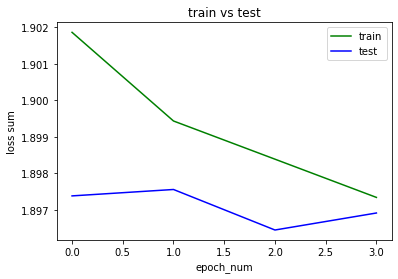

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 23 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60011  


epoch_num = 4  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





neural network with dataloader (то, что работает ) 

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset


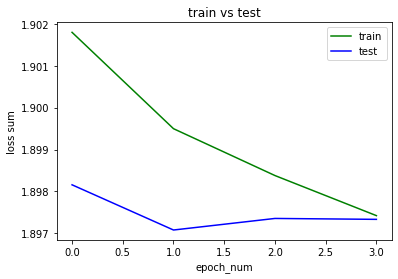

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 23 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60011  


epoch_num = 4  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning:

overflow encountered in multiply



Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Число замеров 100
AUQC: mean:  723797.8087892927 | std:  340631.7282155845
uplift30%: mean:  0.05274711713281108 | std:  0.011127808525418314
Kendall_rank_correlation: mean:  0.42933333333333334 | std:  0.1517041245785407
AUUC: mean:  0.01195040683235274 | std:  0.005543724239963879


In [ ]:
def uplift_at_k(y_target, prediction_score, treatment, rate=0.3):

    check_consistent_length(y_target, prediction_score, treatment)
    prediction_score = np.array(prediction_score)
    order = np.argsort(prediction_score, kind='mergesort')[::-1]
    # order = np.argsort(-prediction_score)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = y_target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = y_target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    return score


In [ ]:
X_test_1 = torch.FloatTensor(X_test_1)
X_test_0 = torch.FloatTensor(X_test_0)

model.eval()

mu_1 = model(X_test_1)
mu_0 = model(X_test_0)

pred = mu_1-mu_0

# print(pred)

# print(torch.min(pred))

pred = pred.detach().numpy()

# print(pred)
# print(y_test)

pred = pred.reshape((-1,)) 
# print(pred)
  
pred = pd.Series(pred, index = y_test.index)

print("qini_auc_score",qini_auc_score(y_test, pred, treatment_test))


print("uplift_at_30%",uplift_at_k(y_test, pred, treatment_test))
# print(y_train[0:10])
# print("------------------")
# print(treatment_train[0:10])






qini_auc_score 8800997.231153477
uplift_at_30% 0.06049210261626348


Text(0.5, 1.0, 'alpha=0.3 - лучший результат')

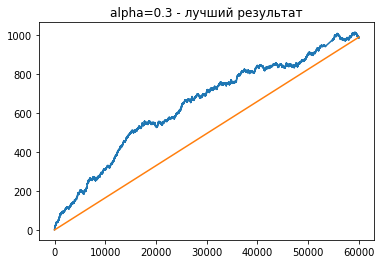

In [ ]:
from UPLIFT_modeling.uplift.metrics import qini_curve
x,y = qini_curve(y_test, pred, treatment_test)
plt.plot(x, y)
plt.plot([ x[0], x[len(x)-1] ], [ y[0], y[len(y) - 1  ]] )
plt.title('alpha=0.3 - лучший результат')

In [ ]:
from UPLIFT_modeling.uplift.vizualization import plot_qini_curve
plot_qini_curve(y_test, pred, treatment_test)

NameError: ignored

6912405.144559544 alpha = 0.2

alpha = 0.0  0

alpha = 0.1 663*10^4   0.048

alpha = 0.2   760*10^4

alpha = 0.3    804*10^4   0.053

alpha = 0.4   605*10^4  0.049

alpha = 0.5   688*10^4 0.054

alpha = 0.6   635*10^4 0.047

alpha = 0.7  728*10^4  0.057

alpha = 0.8  379*10^4 0.051

alpha = 0.9 365*10^4 0.044

alpha = 1.0 145*10^4  0.042


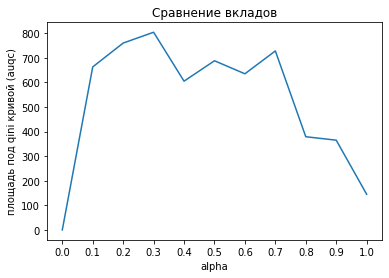

In [ ]:
import matplotlib.pyplot as plt


plt.plot(['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'], [0, 663, 760, 804, 605,688,635,728,379,365,145])
plt.title('Сравнение вкладов каждого из лосс')
plt.xlabel('alpha')
plt.ylabel('площадь под qini кривой (auqc)')

plt.show()

In [ ]:
X_train_1 = torch.FloatTensor(X_train_1)
X_train_0 = torch.FloatTensor(X_train_0)





model.eval()

mu_1 = model(X_train_1)
mu_0 = model(X_train_0)

pred = mu_1-mu_0

print(pred)

pred = pred.detach().numpy()
print(qini_auc_score(y_train, pred, treatment_train))

# print(y_train[0:10])
# print("------------------")
# print(treatment_train[0:10])
# plot_qini_curve(y_train, pred, treatment_train)

# tm_uplift_at_k = uplift_at_k(y_true=y_train, uplift=pred, treatment=treatment_train,
#                              strategy='overall', k=0.3)

print(tm_uplift_at_k)

# print(torch.max(pred))

proposing network with sigmoid





In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 35006   # Number of samples in each batch
epoch_num = 40   # Number of epochs to train the network
lr = 0.0001        # Learning rate





class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)
        

model = Model()
alpha = 0.8

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
# train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_data, batch_size=1)


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters())

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []


model.train()
# epochs loop
for ep in range(epoch_num):  
    print(".......................... epoch =",ep,"..........................")
    i = 0
    # batches loop
    for batch_n in range(batch_per_ep):  
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans_train[i:i+batch_size]

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = treatment_batch.to_numpy()
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
        #convert to torch structure
        batch_label = batch_label.to_numpy()
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)
        batch_Z_trans = torch.reshape(batch_Z_trans, shape = (-1,))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset

    # mu_1 = model(X_test_1_tensor)
    # mu_0 = model(X_test_0_tensor)

    # mu_1_target_class = mu_1
    # mu_0_target_class = mu_0

    # ones = np.ones(shape = X_test_1.shape[0])
    # ones = torch.from_numpy(ones).float()

    # #implements mu = T * mu_1 + (1-T) * mu_0
    # uplift_pred_Y = treatment_test * mu_1_target_class + (ones - treatment_test) * mu_0_target_class 

    # mu_0_target_class = torch.reshape(mu_0_target_class, (-1,))
    # mu_1_target_class = torch.reshape(mu_1_target_class, (-1,))
    

    
   
    
    # #declare losses
    # loss_cross = nn.BCELoss(reduction = 'mean')
    # loss_MSE = nn.MSELoss()

    # #implements uplift_predicted = mu_1 - mu_0
    # uplift_pred = mu_1_target_class - mu_0_target_class 

    # sum_of_losses =torch.mean(  (1-alpha) * loss_MSE(Z_trans_test, uplift_pred) + alpha * loss_cross( uplift_pred_Y, y_test) )
    # test_losses.append(sum_of_losses)

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green')
plt.title('sum_of_losses')
plt.show()

# plt.plot(test_losses, color='blue')
# plt.title('sum_of_losses')
# plt.show()





In [ ]:
X_train_1 = torch.FloatTensor(X_train_1)
X_train_0 = torch.FloatTensor(X_train_0)



model.eval()

mu_1 = model(X_train_1)
mu_0 = model(X_train_0)

pred = mu_1-mu_0
print(qini_auc_score(y_train, pred.detach().numpy(), treatment_train))

print(pred)
print(torch.max(pred))

example of siamese network!!!!
2 out, softmax two classification


 

..........................epoch = 0 ..........................
..........................epoch = 1 ..........................
..........................epoch = 2 ..........................
..........................epoch = 3 ..........................
..........................epoch = 4 ..........................
..........................epoch = 5 ..........................
..........................epoch = 6 ..........................
..........................epoch = 7 ..........................
..........................epoch = 8 ..........................
..........................epoch = 9 ..........................
..........................epoch = 10 ..........................
..........................epoch = 11 ..........................


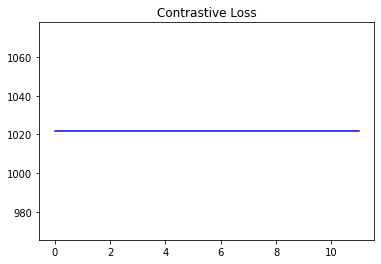

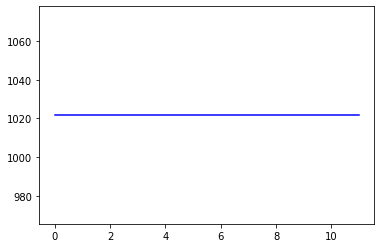

In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 12      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))    # F.log_softmax = log( exp(x_i) / exp(x).sum() )
        #return x



model = Model()
alpha = 0.3


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

X_test_1_tensor = torch.FloatTensor(X_test_1)
X_test_0_tensor = torch.FloatTensor(X_test_0)

treatment_test = treatment_test.to_numpy()
treatment_test = torch.from_numpy(treatment_test).int()
treatment_test = Variable(treatment_test)

y_test = y_test.to_numpy()
y_test = torch.from_numpy(y_test ).float()
y_test  = Variable(y_test )


#convert to torch structure
Z_trans_test = Z_trans_test.to_numpy()
Z_trans_test = torch.from_numpy(Z_trans_test).float()
Z_trans_test = Variable(Z_trans_test)

Z_trans_test = torch.reshape(Z_trans_test, (X_test_1.shape[0],1))

all_losses  = []
test_losses = []
min_losses = []

for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans_train[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = treatment_batch.to_numpy()
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = batch_label.to_numpy()
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        

        
        loss_contrastive = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        
        batch_loss.append(loss_contrastive)
        

        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
        #end for!!!!!!!!!!!!!!!!!!!

    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 
    #work with test dataset

    mu_1 = model(X_test_1_tensor)
    mu_0 = model(X_test_0_tensor)

    mu_1_target_class = mu_1[:,1]
    mu_0_target_class = mu_0[:,1]

    ones = np.ones(shape = X_test_1.shape[0])
    ones = torch.from_numpy(ones).float()

    #implements mu = T * mu_1 + (1-T) * mu_0
    uplift_pred_Y = treatment_test * mu_1_target_class + (ones - treatment_test) * mu_0_target_class 

    mu_0_target_class = torch.reshape(mu_0_target_class, (X_test_1.shape[0],1))
    mu_1_target_class = torch.reshape(mu_1_target_class, (X_test_1.shape[0],1))
    

    
   
    
    #declare losses
    loss_cross = nn.BCELoss(reduction = 'sum')
    loss_MSE = nn.MSELoss()

    #implements uplift_predicted = mu_1 - mu_0
    uplift_pred = mu_1_target_class - mu_0_target_class 

    loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(Z_trans_test, uplift_pred) + alpha * loss_cross( uplift_pred_Y, y_test))
    test_losses.append(loss_contrastive)
    
    # print(qini_auc_score(y_test.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_test.cpu().detach().numpy() ))

import matplotlib.pyplot as plt
plt.plot(all_losses,color='blue')
# plt.plot(test_losses, color='green')
plt.title('Contrastive Loss')
plt.show()

plt.plot(all_losses,color='blue')
plt.show()

In [ ]:

from UPLIFT_modeling.uplift.metrics import uplift_at_k,qini_auc_score

X_test_1 = torch.FloatTensor(X_test_1)
X_test_0 = torch.FloatTensor(X_test_0)

model.eval()

mu_1 = model(X_test_1)
mu_0 = model(X_test_0)

pred = mu_1-mu_0



pred = pred.detach().numpy()





# pred = pred.reshape((-1,)) 

  
# pred = pd.Series(pred, index = y_test.index)


print(y_test.shape)
print(pred.shape)
print(treatment_test.shape)

print("qini_auc_score",qini_auc_score(y_test, pred[:,0], treatment_test))


print("uplift_at_30%",uplift_at_k(y_test, pred, treatment_test))
# print(y_train[0:10])
# print("------------------")
# print(treatment_train[0:10])



torch.Size([60011])
(60011, 2)
torch.Size([60011])
qini_auc_score 0.0


ValueError: ignored

In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 20      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))
        #return x



model = Model()
alpha = 0.8


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)







Z_trans_test = torch.reshape(Z_trans_test, (X_test_1.shape[0],1))
all_losses  = []
min_losses =[]
for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 

        loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))

        batch_loss.append(loss_contrastive)
        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title('Contrastive Loss')
plt.show()

TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_losses[:210000])
plt.title('Contrastive Loss')
plt.show()